In [139]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2
from scipy.stats import spearmanr,pearsonr
from CCIT import CCIT


In [142]:
#defining the class MDN
class MDN_module(tf.keras.Model):
#changed from 15 to 20
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [143]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        #changing x to -1
        indices_0 = [i for i, x in enumerate(x_test) if x == -1]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [144]:
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [145]:
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == -1]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [146]:
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [147]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    #eps0 = np.random.standard_normal(1000)
    #eps1 = np.random.standard_normal(1000)
    eps0 = np.random.normal(0,1,1000)
    eps1 = np.random.normal(0,1,1000)
    A = beta0 + beta1*L + eps0
    #B=beta2+beta3*np.sin(A)+eps1
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [8]:
yeast=open("../yeast_full_data/yeast_residual_data_full_62k_gt1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,62296):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


KeyboardInterrupt: 

In [ ]:
plt.scatter(dataset_0[2732][1],dataset_0[2732][2])

In [ ]:
L=np.array(dataset_0[2732][0])
A=np.array(dataset_0[2732][1])
B=np.array(dataset_0[2732][2])

In [ ]:
open("dataset_params.txt", "r")

In [148]:
fo=open("/home/aravind/projects/CIT_Non_Linear/LinearDifferentvalues/testing_writingvalues_diff_variance.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,121):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [149]:
L=dataset_linear[3][0]
A=dataset_linear[3][1]
B=dataset_linear[3][2]

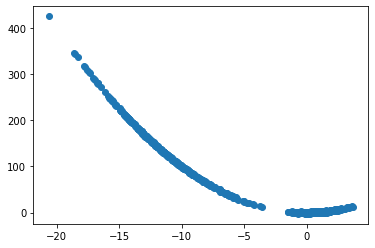

In [150]:
plt.scatter(A,B)

In [ ]:
yeast=open("../yeast_full_data/yeast_residual_data_full_209k_gt2.txt","r")
L=[]
A=[]
B=[]
for i in range(0,209157):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]

In [ ]:
read_file = open("indicesUsedIndependent.pkl", "rb")
indices=pickle.load(read_file)
read_file.close()

In [ ]:
dataset_yeast10k_ind=[dataset_0[q] for q in indices]

In [ ]:
read_file = open("indicesUsedIndependent.pkl", "rb")
indices=pickle.load(read_file)
read_file.close()

In [ ]:
fo=open("./LinearDifferentvalues/testing_writingvalues_Indpendent.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,100):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [ ]:
import os
os.getcwd()

In [ ]:
fer=open("../LinearDifferentvalues/dataset_params_Linear0to1.txt","r")
dataset_names=[]
for i in range(0,121):
    line=fer.readline()
    line="_".join(line.split())
    dataset_names.append(line)
fer.close()

In [152]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(abs(i) < abs(original) for i in loss_list)/len(loss_list)
    
    

In [153]:
def compute_third_testloss(A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(A)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    return -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [154]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [155]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changing x== -1 
    indices_0 = [i for i, x in enumerate(L) if x == -1]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        loss.append(calculate_difference(L,A,B_dist_temp))
    return loss

In [ ]:
import math

In [29]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


In [ ]:
np.heaviside(1,0)

In [ ]:
def hill(x,n):
    return x**n / (1+x**n)

In [ ]:
L = np.random.binomial(1,0.5,1000)  
L[L==0]=-1

In [ ]:
eps0 = np.random.normal(0,1,1000)
eps1 = np.random.normal(0,1,1000)
A = L + eps0
B = abs(A)+eps1

In [ ]:
plt.scatter(A,B)

In [ ]:
min(A)

In [ ]:
L=L[A<3]
B=B[A<3]
A=A[A<3]

In [ ]:
L = np.random.binomial(1,0.5,1000)  
eps0 = np.random.normal(0,1,1000)
eps1 = np.random.normal(0,1,1000)
A = 10*L + eps0**2
B = 10*L+eps1
#A =5*L+ eps0
#B = 5*L+eps1
#A = L + eps0
#B = hill(A,20)+eps1

In [ ]:
L=dataset_linear[0][0]
A=dataset_linear[0][1]
B=dataset_linear[0][2]

In [ ]:
len(L)

In [ ]:
np.sin(1)*10

In [ ]:
plt.scatter(A,B)
plt.xlabel("A")

plt.ylabel("B")

In [ ]:
plt.scatter(L,A)

In [ ]:
plt.scatter(L,B)

In [ ]:
plt.scatter(A,B)

In [156]:
i=44
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])

In [104]:
    i=3
   
    shuffles=100
    A_shuffle=np.copy(A)
    B_shuffle=np.copy(B)
    #print("Original",B_shuffle)
    #changed the second test from mle to using neural networks
    loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
    loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
    loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
    true_LA=compute_loss(L,A,True)
    true_LB=compute_loss(L,B,True)
    true_LBresidual=calculate_difference(L,A,B)
    LA_p=calculate_pvalue(true_LA,loss_list_LA)
    LB_p=calculate_pvalue(true_LB,loss_list_LB)
    AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
    #f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
    #file_name=str(dataset_names[i])+".pkl"
    #open_file = open("./DLresultspickle/"+file_name, "wb")
    #pickle.dump(pickle_items, open_file)
    #open_file.close()

In [108]:
 true_LBresidual=calculate_difference(L,A,B)

In [15]:
LA_p=calculate_pvalue(true_LA,loss_list_LA)
LB_p=calculate_pvalue(true_LB,loss_list_LB)
AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)

In [95]:
AB_p

0.0

In [109]:
true_LBresidual

-0.40113497

In [106]:
loss_list_Bresidual

[0.1034255,
 0.21530747,
 0.2973969,
 0.1493783,
 0.20811844,
 0.19837022,
 0.14677954,
 0.15828586,
 0.26463056,
 0.21028686,
 0.21576309,
 0.24720073,
 0.10089111,
 0.38521934,
 0.29315948,
 0.24277973,
 0.2861731,
 0.1361661,
 0.22935343,
 0.22031498,
 0.13785648,
 0.26345634,
 0.10739279,
 0.2706716,
 -0.09165287,
 -0.013129234,
 -0.022650719,
 0.15366268,
 0.19499588,
 0.17260051,
 0.22359538,
 0.29292727,
 0.20893192,
 0.2250719,
 0.1461339,
 0.17099476,
 0.20526218,
 0.13453603,
 0.08206415,
 0.17685318,
 0.1968031,
 0.2246387,
 -50.663853,
 0.4532671,
 0.23932672,
 0.022576332,
 0.080266714,
 0.22540236,
 0.22494268,
 0.30157804,
 0.13468552,
 0.17605066,
 -14.51969,
 0.21334195,
 0.16230607,
 0.21066332,
 0.16581249,
 0.22201538,
 0.33798552,
 0.09794617,
 0.20945358,
 0.25111055,
 0.10890293,
 0.21075892,
 0.23340821,
 0.09951162,
 0.24993587,
 0.19420552,
 0.12784195,
 0.24397397,
 0.24710274,
 0.3585434,
 0.20219326,
 0.17110968,
 0.25668287,
 0.17077684,
 0.054103374,
 0.3

In [98]:
[i < true_LBresidual for i in loss_list_Bresidual]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

/home/aravind/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: setting an array element with a sequence.

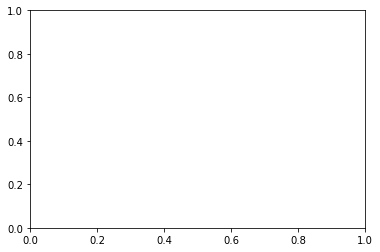

In [14]:
plt.scatter(A,B)
plt.xlabel("A")
plt.ylabel("B")

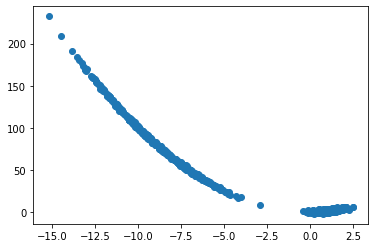

In [127]:
plt.scatter(A,B)

In [107]:
#print(dataset_names[120])
print(LA_p)
print(LB_p)
print(AB_p)

0.0
0.0
1.0


In [19]:
len(A)

1000

In [ ]:
loss_list_LB

In [ ]:
true_LB

In [ ]:
plt.scatter(L,B)

In [171]:
i=120
#A=np.array(dataset_linear[i][1])
#B=np.array(dataset_linear[i][2])
#L=np.array(dataset_linear[i][0])
opt = tf.optimizers.Nadam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


In [172]:
alpha,mu,sigma = slice_parameter_vectors(y_pred)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [173]:
loss

2.8781264

Text(0.5, 1.0, 'Original data with added information of L')

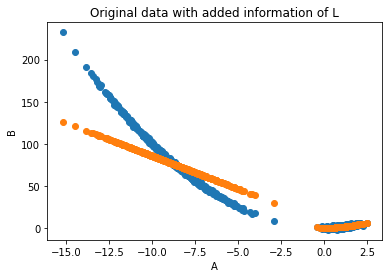

In [174]:
plt.scatter(A,B)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data with added information of L")

In [64]:
L = np.random.binomial(1,0.5,1000)  
eps0 = np.random.normal(0,0.1,1000)
eps1 = np.random.normal(0,0.1,1000)
A = 1*L + eps0
#B=beta2+beta3*np.sin(A)+eps1
B =1*A + eps1 

In [175]:
i=39
#A=np.array(dataset_linear[i][1])
#B=np.array(dataset_linear[i][2])
#L=np.array(dataset_linear[i][0])
opt = tf.optimizers.Nadam(1e-2)
mdn_PQ = MDN_module()

mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B.T,epochs=100,  batch_size=64,verbose=0)
y_pred_withoutL = mdn_PQ.predict(reshapevar(A))


In [176]:
alpha,mu,sigma = slice_parameter_vectors(y_pred_withoutL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [177]:
loss

3.517109

Text(0.5, 1.0, 'Original data without the added information L')

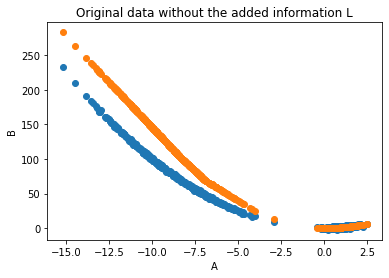

In [178]:
plt.scatter(A,B)
plt.scatter(A,y_pred_withoutL[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data without the added information L")


In [117]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
#changed x=0 to x=-1
indices_0 = [i for i, x in enumerate(L) if x == -1]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]

In [118]:
B_dist_temp

array([ 1.16363142e+02,  5.56306026e+00,  7.29531353e+00,  1.30750943e+00,
        2.92144654e+00,  4.16270666e+01,  1.09038177e+02,  1.23302358e+02,
        7.24326496e-01, -1.35779405e+00, -1.02982484e+00,  1.28467787e+02,
        7.52428066e+00,  1.19926406e+00,  1.61357223e+02,  5.41667627e-01,
        1.01900962e+02,  1.84004039e+02,  1.66693581e+00,  1.59868620e+02,
        2.52802773e+02,  6.79662797e-01,  1.43006457e+01,  2.64261736e+00,
        6.42216204e-01,  7.09271409e+01,  4.03461447e-01,  1.06480998e+02,
        1.81214914e+02,  3.83176976e-01,  3.46671351e+02,  1.52716266e+02,
        9.61387681e+01,  7.95548775e+00,  2.92340425e+02,  3.22307236e+00,
        3.18472288e+00, -9.25582080e-01,  1.46218510e+00,  2.54206414e+00,
       -8.34141567e-01,  6.36159810e+01,  4.11966282e+01, -1.62809753e+00,
        1.41238364e+00,  3.90570196e+00,  1.78666604e+02,  3.41326778e+01,
        1.17348492e+02,  8.37646617e-01,  1.69284669e+00,  1.03345808e+02,
        1.38215177e+02,  

In [119]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=100,  batch_size=64,verbose=0)
y_pred_permL = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


In [120]:
alpha,mu,sigma = slice_parameter_vectors(y_pred_permL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [121]:
loss

3.8251884

Text(0.5, 1.0, 'Permuted data with the added information L')

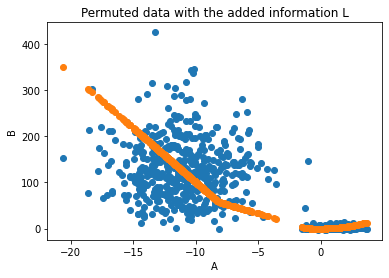

In [122]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data with the added information L")

In [ ]:
plt.scatter(L,B_dist_temp)

In [ ]:
y_pred[:,1]

In [123]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B_dist_temp.T,epochs=100,  batch_size=64,verbose=0)
y_pred_permwithoutL = mdn_PQ.predict(reshapevar(A))

In [124]:
alpha,mu,sigma = slice_parameter_vectors(y_pred_permwithoutL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [38]:
loss

3.9796891

Text(0.5, 1.0, 'Permuted data without the added information')

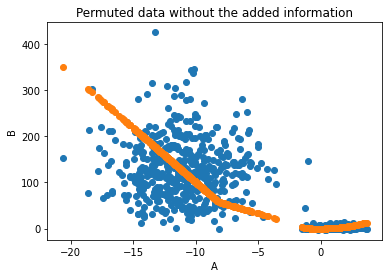

In [125]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data without the added information")

In [ ]:
L = np.random.binomial(1,0.5,1000)  
#eps0 = np.random.standard_normal(1000)
#eps1 = np.random.standard_normal(1000)
eps0 = np.random.normal(-2,0.5,1000)
eps1 = np.random.normal(-5,0.5,1000)
A=9*L - eps0
B=8*np.sin(A)+eps1

In [ ]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]

In [ ]:
plt.scatter(L,A)
plt.title("L vs A")
plt.xlabel("L")
plt.ylabel("A")

In [ ]:
plt.scatter(L,B)
plt.title("L vs B")
plt.xlabel("L")
plt.ylabel("B")

In [ ]:
plt.scatter(A[indices_1],B[indices_1],label="L=1")
plt.scatter(A[indices_0],B[indices_0],label="L=0")
plt.title("A vs B")
plt.xlabel("A")
plt.ylabel("B")
plt.legend()

In [ ]:
plt.scatter(A,B)
plt.title("Simulated data")
plt.xlabel("A")
plt.ylabel("B")

In [ ]:
str(pearsonr(A,B)[0])

In [ ]:
f = open("testing_writingvalues_debugSine.txt", "w")
f.write(str(9)+" "+ str(8))
f.write("\n")
np.savetxt(f,L,newline=' ',fmt='%s')
f.write("\n")
np.savetxt(f,A,newline=' ',fmt='%s')
f.write("\n")
np.savetxt(f,B,newline=' ',fmt='%s')
f.write("\n")
f.close()
